In [5]:
from os import listdir
from os.path import join
from scipy import io
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
root_dir_zero = "/home/osamaazhar/0"    
zero = listdir(root_dir_zero)

root_dir_one = "/home/osamaazhar/1"
one = listdir(root_dir_one)

root_dir_two = "/home/osamaazhar/2"
two = listdir(root_dir_two)

root_dir_three = "/home/osamaazhar/3"
three = listdir(root_dir_three)

In [8]:
def data_to_dict(file_name, root_dir, condition):
    dataframes = []
    for sub_dir in file_name:
        if 'readme' not in sub_dir:
            mat = io.loadmat(join(root_dir, sub_dir))
            features = ['AE', 'disp', 'power', 'sound']
            feat_dict = {}
            for i, feat in enumerate(features):
                feat_dict[feat] = mat["processed"][0][0][i].flatten()
            dataframes.append(pd.DataFrame(feat_dict, index=np.arange(len(mat["processed"][0][0][0]))))
    return dataframes

In [9]:
all_files = []
zero_dict = data_to_dict(zero, root_dir_zero, 0)
one_dict = data_to_dict(one, root_dir_one, 1)
two_dict = data_to_dict(two, root_dir_two, 2)
three_dict = data_to_dict(three, root_dir_three, 3)
all_files.append(zero_dict)
all_files.append(one_dict)
all_files.append(two_dict)
all_files.append(three_dict)

In [10]:
data = []
for i, f in enumerate(all_files):
    for df in f:
            data.append([df[:100000], i])
print(len(data))

# for i in range(len(data)):
#     print(len(data[i][0]))

200


In [11]:
class TSdata(Dataset):
    def __init__(self, data, downsampling_factor, lists_ratio=1):
        self.x = []
        self.y = []
        self.data = data
        self.downsampling_factor = downsampling_factor
        self.lists_ratio = lists_ratio
        self.data_to_tensor()
    
    def data_to_tensor(self):
        """Not a fast implementation
            but works for the purposes
            of this project"""
        for index in range(len(self.data)):
            df = self.data[index][0]
            if self.lists_ratio == 1:
                for sample_offset in range(self.downsampling_factor):
                    self.y.append(torch.tensor(self.data[index][1], dtype = torch.long))
                    self.x.append(torch.tensor(df[["AE", "disp", "power", "sound"]]
                                          .values[sample_offset::self.downsampling_factor],
                                          dtype = torch.double))
            else:
                for _ in range(int(self.downsampling_factor * self.lists_ratio)):
                    sample_offset = torch.randint(0, self.downsampling_factor, ()).item()
                    self.y.append(torch.tensor(self.data[index][1], dtype = torch.long))
                    self.x.append(torch.tensor(df[["AE", "disp", "power", "sound"]]
                                          .values[sample_offset::self.downsampling_factor],
                                          dtype = torch.double))
                    
        
        
    def __getitem__(self, index):
        return [self.x[index], self.y[index]]
    
    def __len__(self):
        return len(self.y)

## Dataset/Dataloader Configuration

In [14]:
batch_size = 10
input_size = 4
seq_len = 1000
num_layers = 4
hidden_size = 32
num_classes = 4
learning_rate = 2e-3
num_epochs = 50
downsampling = 100
lists_ratio = 0.2

train_data, test_data = random_split(data, [170, 30])
train_dataset = TSdata(train_data, downsampling_factor=downsampling, lists_ratio=lists_ratio)
test_dataset  = TSdata(test_data, downsampling_factor=downsampling, lists_ratio=lists_ratio)
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
test_loader  = DataLoader(test_dataset,  batch_size, shuffle = True)

print(len(train_loader))

340


# LSTM 

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device):
        super(LSTM,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True).to(device)
        #x -> (batch_size, seq_len, input_size)
        self.fc = nn.Linear(hidden_size, num_classes).to(device)
    
    def forward(self,x):
        
        x = x.double()
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device).double()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device).double()

        
        out, _ = self.rnn(x, (h0, c0))
        
        #out ->  (batch_size, seq_len, hidden_size)
        
        out = out[: , -1, :]
        
        # out -> (batch_size, hidden_size)
        
        out = self.fc(out)
        
        return out

In [16]:
model = LSTM(input_size, hidden_size, num_layers, num_classes, device=device).double()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
#Training the LSTM:

total_train_loss = []

total_val_loss = []


total_steps = len(train_loader)

for epoch in range(num_epochs):
    avg_loss = []
    avg_acc = []
    for i, (signals, label) in enumerate(train_loader):
                # forward pass
        signals, label = signals.to(device), label.to(device)
        outputs = model(signals)
        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        loss = criterion(outputs, label)
        #backward and optimization 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accuracy calculation
        correct = (predictions == label).sum().item()
        train_accuracy = correct/batch_size
        #print(train_accuracy)
        
        avg_loss.append(loss.item())
        avg_acc.append(train_accuracy)
    
    x = np.average(avg_loss)
    y = np.average(avg_acc)
    total_train_loss.append(x)
    
    print(f'trained on epoch #{epoch + 1}, avg_train_loss: {x}, avg_train_acc: {y}')
        
        
    
    model.eval()
    
    avg_val_loss = []
    avg_test_acc = []
    
    for i, (signals_test, label_test) in enumerate(test_loader):
        signals_test, label_test = signals_test.to(device), label_test.to(device)
        output_test = model(signals_test)
        
        val_loss = criterion(output_test, label_test)
        
        
        avg_val_loss.append(val_loss.item())
        
         # Accuracy calculation
        correct = (predictions == label).sum().item()
        test_accuracy = correct/batch_size
        
        avg_test_acc.append(test_accuracy)
        
        #print(test_accuracy)
    
    x1 = np.average(avg_val_loss)
    y1 = np.average(avg_test_acc)    
    total_val_loss.append(x1)
    
    print(f'tested on epoch #{epoch + 1}, avg_val_loss: {x1}, avg_test_acc:{y1}')
        
    model.train()
    print(f'epoch [{epoch + 1} / {num_epochs}], Step [{i+1}/ {total_steps}], Loss: {loss.item()}, Val Loss: {val_loss.item()}')


trained on epoch #1, avg_train_loss: 1.3738839472195208, avg_train_acc: 0.2802941176470588
tested on epoch #1, avg_val_loss: 1.1821202976904133, avg_test_acc:0.6000000000000001
epoch [1 / 50], Step [60/ 340], Loss: 1.17507293888143, Val Loss: 1.2076421507255712
trained on epoch #2, avg_train_loss: 1.1176861726986984, avg_train_acc: 0.48970588235294116
tested on epoch #2, avg_val_loss: 1.1961285568455702, avg_test_acc:0.5
epoch [2 / 50], Step [60/ 340], Loss: 1.2170874203722826, Val Loss: 1.57286754464495
trained on epoch #3, avg_train_loss: 1.0723849281714743, avg_train_acc: 0.49470588235294116
tested on epoch #3, avg_val_loss: 1.0833548856556683, avg_test_acc:0.39999999999999986
epoch [3 / 50], Step [60/ 340], Loss: 1.3621054551998726, Val Loss: 0.8828254833655802
trained on epoch #4, avg_train_loss: 1.04537062717232, avg_train_acc: 0.5194117647058824
tested on epoch #4, avg_val_loss: 1.3982782483428409, avg_test_acc:0.39999999999999986
epoch [4 / 50], Step [60/ 340], Loss: 1.24391338

In [18]:
print(total_val_loss)
val_loss = np.around(total_val_loss, decimals = 7) 
len(total_val_loss)

[1.1821202976904133, 1.1961285568455702, 1.0833548856556683, 1.3982782483428409, 0.6473016641970435, 0.5860586589060554, 0.9821007998874496, 0.5300548108275167, 0.3545305601039379, 0.297052963296051, 0.239210667758779, 0.26409465879089217, 0.1430664483316001, 0.13393016113091571, 0.0727320532864793, 0.11934908621427769, 0.07828999327717069, 0.05101190437705528, 0.13980657811775055, 0.032152087009422355, 0.0515316623004383, 0.10452373945020292, 0.09727681716869949, 0.051435986472692576, 0.00856954521291942, 0.03337716209699409, 0.1261551621051809, 0.032167317375387965, 0.013565569170595206, 0.08311658140355108, 0.028585100697156876, 0.02328312891248148, 0.024084758050746287, 0.009750951874208805, 0.00730599533736742, 0.013536220055602316, 0.016505569308047988, 0.012005994652061947, 0.02944823633647403, 0.01586009025015585, 0.1724087217457617, 0.008625094056023562, 0.01382428145642859, 0.015548491762621517, 0.005634816838747348, 0.004077993467703028, 0.00435376327666582, 0.00348014603362

50

In [19]:
print(total_train_loss)
train_loss = np.around(total_train_loss, decimals = 7) 
print(train_loss)
len(total_train_loss)

[1.3738839472195208, 1.1176861726986984, 1.0723849281714743, 1.04537062717232, 0.9626743154881002, 0.7862156230256696, 0.6978589717921388, 0.7257137339252999, 0.5883321569458045, 0.55533297712663, 0.4530562609627934, 0.3524027746420447, 0.26466624994363375, 0.22835552985730612, 0.19535020002843775, 0.19072550440686675, 0.13487296216038963, 0.12096903142716448, 0.11696774867658963, 0.11094647762028614, 0.09360924861913986, 0.09863530741155875, 0.050397406789603284, 0.057801255542085934, 0.060527481379837336, 0.08156531093697512, 0.04511053408813127, 0.08137829839473422, 0.0414087687460215, 0.08996491163523723, 0.13070133525596908, 0.05747005960947544, 0.06608499747998878, 0.03901429580265126, 0.018320747607966818, 0.03747970079927836, 0.05403579508784559, 0.023674299984748917, 0.00882721597960795, 0.003180983705082564, 0.06395349257214633, 0.06360740858992668, 0.01134632013163838, 0.004202113140692678, 0.0007993301234768968, 0.0004545962538125556, 0.00032406284384027957, 0.0002513228444

50

minimum training loss = 0.0001548


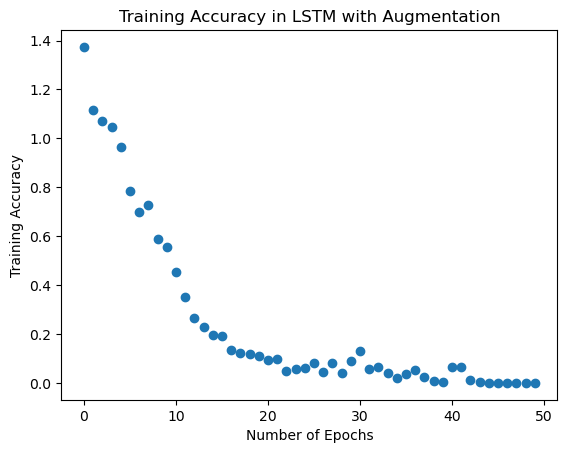

In [20]:
print(f'minimum training loss = {np.min(train_loss)}')

x = np.array(range(0, num_epochs))
plt.scatter(x, train_loss)
plt.title("Training Accuracy in LSTM with Augmentation")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Accuracy")

plt.show()

minimum validation loss = 0.0034801


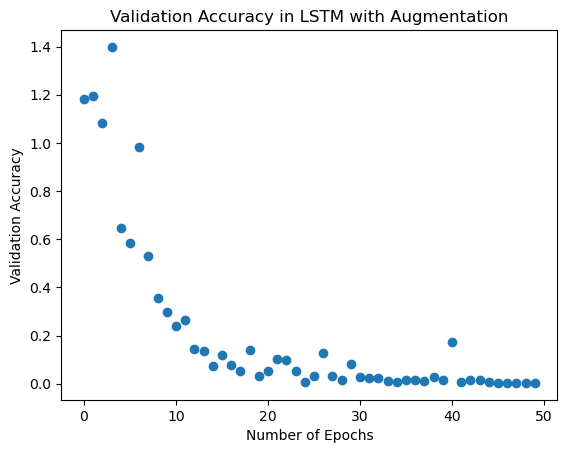

In [21]:
print(f'minimum validation loss = {np.min(val_loss)}')

x1 = np.array(range(0, num_epochs))
plt.title("Validation Accuracy in LSTM with Augmentation")
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Accuracy")
plt.scatter(x1, val_loss)
plt.show()

In [35]:
print(torch.manual_seed(6))